In [1]:
#import talib
import os
import numpy as np
import pandas as pd
import pickle
#import quandl
import datetime
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Convolution2D,MaxPooling2D,Activation,Reshape,Permute
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.layers import LSTM,Bidirectional

In [2]:
finalprice=pd.read_csv('fianaldata.csv',index_col='date')
finalprice.index=pd.to_datetime(finalprice.index,format="%Y-%m-%d")
finalprice=finalprice['2016-10-30':'2019-03-31']
finalprice.replace(0,np.nan,inplace=True)
finalprice=finalprice.fillna(method='pad')

In [3]:
price= finalprice.loc['2018-04-01':'2019-03-31',['Close']]
price=price.values
trueprice=finalprice.loc['2018-04-01':'2019-03-31',['predict']]
forecase=np.zeros((365,))

In [4]:
final=finalprice['2017-10-30':'2018-04-30']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-30)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-30-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-30),1)
test_x=np.array(test_x)
test_x=test_x.reshape(30,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(30,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(30,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(30,)

for i in range(365-365,395-365): 
    forecase[i]=Yhat[i-365+365]    


In [5]:
final=finalprice['2017-11-29':'2018-05-31']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-31)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-31-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-31),1)
test_x=np.array(test_x)
test_x=test_x.reshape(31,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(31,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(31,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(31,)

for i in range(395-365,426-365): 
    forecase[i]=Yhat[i-395+365]    
forecase

array([7337.66210938, 7481.45019531, 8059.94921875, 7894.15625   ,
       7557.1640625 , 7483.54833984, 7944.25488281, 8159.14404297,
       8063.70898438, 7602.93359375, 7759.49804688, 7953.22216797,
       8424.10546875, 8427.77734375, 8708.43652344, 8511.53515625,
       8051.078125  , 8272.2109375 , 8355.8203125 , 8731.16796875,
       8900.95898438, 8663.87890625, 8655.41503906, 9201.36621094,
       8577.10644531, 8720.04882812, 8891.36523438, 9010.55761719,
       9184.20996094, 8973.65234375, 9096.38867188, 9090.03417969,
       9434.1953125 , 9355.67480469, 9368.40820312, 9309.70605469,
       9084.30859375, 8861.21777344, 9096.6875    , 8859.46191406,
       8734.9609375 , 8879.79785156, 9250.16894531, 9062.82324219,
       8961.74414062, 8890.04882812, 8711.57421875, 8673.21875   ,
       8604.26367188, 8689.95117188, 8655.94824219, 8652.36230469,
       8434.68457031, 8246.23730469, 8266.31152344, 8446.33691406,
       8616.44140625, 8446.52050781, 8352.7890625 , 8272.20703

In [6]:
final=finalprice['2017-12-30':'2018-06-30']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-30)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-30-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-30),1)
test_x=np.array(test_x)
test_x=test_x.reshape(30,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(30,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(30,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(30,)

for i in range(426-365,456-365): 
    forecase[i]=Yhat[i-426+365]    


In [7]:
final=finalprice['2018-01-30':'2018-07-31']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-31)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-31-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-31),1)
test_x=np.array(test_x)
test_x=test_x.reshape(31,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(31,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(31,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(31,)

for i in range(456-365,487-365): 
    forecase[i]=Yhat[i-456+365]    


In [8]:
final=finalprice['2018-02-27':'2018-08-31']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-31)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-31-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-31),1)
test_x=np.array(test_x)
test_x=test_x.reshape(31,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(31,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(31,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(31,)

for i in range(487-365,518-365): 
    forecase[i]=Yhat[i-487+365]    


In [9]:
final=finalprice['2018-03-30':'2018-09-30']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-30)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-30-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-30),1)
test_x=np.array(test_x)
test_x=test_x.reshape(30,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(30,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(30,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(30,)

for i in range(518-365,548-365): 
    forecase[i]=Yhat[i-518+365]    


In [10]:
final=finalprice['2018-04-29':'2018-10-31']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-31)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-31-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-31),1)
test_x=np.array(test_x)
test_x=test_x.reshape(31,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(31,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(31,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(31,)

for i in range(548-365,579-365): 
    forecase[i]=Yhat[i-548+365]    
forecase

array([7337.66210938, 7481.45019531, 8059.94921875, 7894.15625   ,
       7557.1640625 , 7483.54833984, 7944.25488281, 8159.14404297,
       8063.70898438, 7602.93359375, 7759.49804688, 7953.22216797,
       8424.10546875, 8427.77734375, 8708.43652344, 8511.53515625,
       8051.078125  , 8272.2109375 , 8355.8203125 , 8731.16796875,
       8900.95898438, 8663.87890625, 8655.41503906, 9201.36621094,
       8577.10644531, 8720.04882812, 8891.36523438, 9010.55761719,
       9184.20996094, 8973.65234375, 9096.38867188, 9090.03417969,
       9434.1953125 , 9355.67480469, 9368.40820312, 9309.70605469,
       9084.30859375, 8861.21777344, 9096.6875    , 8859.46191406,
       8734.9609375 , 8879.79785156, 9250.16894531, 9062.82324219,
       8961.74414062, 8890.04882812, 8711.57421875, 8673.21875   ,
       8604.26367188, 8689.95117188, 8655.94824219, 8652.36230469,
       8434.68457031, 8246.23730469, 8266.31152344, 8446.33691406,
       8616.44140625, 8446.52050781, 8352.7890625 , 8272.20703

In [11]:
final=finalprice['2018-05-30':'2018-11-30']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-30)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-30-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-30),1)
test_x=np.array(test_x)
test_x=test_x.reshape(30,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(30,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(30,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(30,)

for i in range(579-365,609-365): 
    forecase[i]=Yhat[i-579+365]    
forecase

array([7337.66210938, 7481.45019531, 8059.94921875, 7894.15625   ,
       7557.1640625 , 7483.54833984, 7944.25488281, 8159.14404297,
       8063.70898438, 7602.93359375, 7759.49804688, 7953.22216797,
       8424.10546875, 8427.77734375, 8708.43652344, 8511.53515625,
       8051.078125  , 8272.2109375 , 8355.8203125 , 8731.16796875,
       8900.95898438, 8663.87890625, 8655.41503906, 9201.36621094,
       8577.10644531, 8720.04882812, 8891.36523438, 9010.55761719,
       9184.20996094, 8973.65234375, 9096.38867188, 9090.03417969,
       9434.1953125 , 9355.67480469, 9368.40820312, 9309.70605469,
       9084.30859375, 8861.21777344, 9096.6875    , 8859.46191406,
       8734.9609375 , 8879.79785156, 9250.16894531, 9062.82324219,
       8961.74414062, 8890.04882812, 8711.57421875, 8673.21875   ,
       8604.26367188, 8689.95117188, 8655.94824219, 8652.36230469,
       8434.68457031, 8246.23730469, 8266.31152344, 8446.33691406,
       8616.44140625, 8446.52050781, 8352.7890625 , 8272.20703

In [12]:
final=finalprice['2018-06-29':'2018-12-31']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-31)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-31-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-31),1)
test_x=np.array(test_x)
test_x=test_x.reshape(31,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(31,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(31,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(31,)

for i in range(609-365,640-365): 
    forecase[i]=Yhat[i-609+365]    


In [13]:
final=finalprice['2018-07-30':'2019-01-31']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-31)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-31-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-31),1)
test_x=np.array(test_x)
test_x=test_x.reshape(31,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(31,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(31,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(31,)

for i in range(640-365,671-365): 
    forecase[i]=Yhat[i-640+365]    


In [14]:
final=finalprice['2018-08-30':'2019-02-28']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-28)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-28-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-28),1)
test_x=np.array(test_x)
test_x=test_x.reshape(28,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(28,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(28,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(28,)

for i in range(671-365,699-365): 
    forecase[i]=Yhat[i-671+365]    


In [15]:
final=finalprice['2018-09-29':'2019-03-31']

data=final.values
def get_train_data(batch_size=1,time_step=3,train_begin=0,train_end=(len(final)-31)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    mean=np.mean(data_train,axis=0)
    std=np.std(data_train,axis=0)
    normalized_train_data=(data_train-mean)/std
    size=(len(normalized_train_data)+time_step-1)//time_step
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step+1):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:17]
        #y=normalized_train_data[i:i+time_step,17,np.newaxis]
        y=normalized_train_data[i+time_step-1,17,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    return mean,std,train_x,train_y
mean,std,train_x,train_y=get_train_data()
def get_test_data(time_step=3,test_begin=(len(final)-31-2)):
    data_test=data[test_begin:]
    normalized_test_data=(data_test-mean)/std
   # size=(len(normalized_test_data)+time_step-1)//time_step
    size=(len(normalized_test_data)-time_step+1)
    test_x,test_y=[],[]
    for i in range(size):
        #x=normalized_test_data[i*time_step:(i+1)*time_step,:17]
        #y=normalized_test_data[i*time_step:(i+1)*time_step,17]
        x=normalized_test_data[i:i+time_step,:17]
        y=normalized_test_data[i+time_step-1,17,np.newaxis]
        test_x.append(x.tolist())
        test_y.append(y.tolist())
    return test_x,test_y
test_x,test_y=get_test_data()
train_x=np.array(train_x)
train_x=train_x.reshape(train_x.shape[0],3,17,1)
train_y=np.array(train_y)
train_y=train_y.reshape((len(final)-2-31),1)
test_x=np.array(test_x)
test_x=test_x.reshape(31,3,17,1)
test_y=np.array(test_y)
test_y=test_y.reshape(31,1)

model = Sequential()
model.add(Convolution2D(
    input_shape=(3,
                 17,
                1),
   kernel_size=(2,2),
    filters=15,
    padding='same'
))

model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same'))
#model.add(Dropout(0.2))

model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))



model.add(Convolution2D(
    input_shape=(3,
                 17,
                 1),
    kernel_size=(2,2),
    filters=15,
    padding='same'
))


model.add(Flatten())
model.add(Dense(25))
model.add(Activation('relu'))


#model.add(Dense(15))


model.add(Reshape((1,25),input_shape=(25,)))
#model.add(Permute(1,15))
#model = Sequential()
model.add(LSTM(50,return_sequences=False))

#model.add(LSTM(30, input_shape=(1, 50),return_sequences=False))
#model.add(Dropout(0.3))
#model.add(LSTM(15,return_sequences=True))

#model.add(LSTM(10,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dropout(0.1))

adam=Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=50, validation_data=(test_x, test_y), verbose=0,shuffle=False)
    
test_y=np.array(test_y)
yhat = model.predict(test_x)
Yhat=yhat*std[17]+mean[17]
Test_y=test_y*std[17]+mean[17]
Test_y=Test_y.reshape(31,)
Yhat=np.array(Yhat)
Yhat=Yhat.reshape(31,)

for i in range(699-365,730-365): 
    forecase[i]=Yhat[i-699+365]    
forecase

array([7337.66210938, 7481.45019531, 8059.94921875, 7894.15625   ,
       7557.1640625 , 7483.54833984, 7944.25488281, 8159.14404297,
       8063.70898438, 7602.93359375, 7759.49804688, 7953.22216797,
       8424.10546875, 8427.77734375, 8708.43652344, 8511.53515625,
       8051.078125  , 8272.2109375 , 8355.8203125 , 8731.16796875,
       8900.95898438, 8663.87890625, 8655.41503906, 9201.36621094,
       8577.10644531, 8720.04882812, 8891.36523438, 9010.55761719,
       9184.20996094, 8973.65234375, 9096.38867188, 9090.03417969,
       9434.1953125 , 9355.67480469, 9368.40820312, 9309.70605469,
       9084.30859375, 8861.21777344, 9096.6875    , 8859.46191406,
       8734.9609375 , 8879.79785156, 9250.16894531, 9062.82324219,
       8961.74414062, 8890.04882812, 8711.57421875, 8673.21875   ,
       8604.26367188, 8689.95117188, 8655.94824219, 8652.36230469,
       8434.68457031, 8246.23730469, 8266.31152344, 8446.33691406,
       8616.44140625, 8446.52050781, 8352.7890625 , 8272.20703

In [16]:
from matplotlib import pyplot
%matplotlib inline
trueprice=trueprice.values

<function matplotlib.pyplot.show(*args, **kw)>

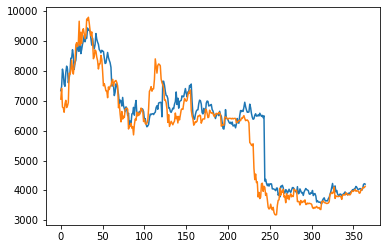

In [17]:

pyplot.plot(forecase)
pyplot.plot(trueprice)
pyplot.show

<function matplotlib.pyplot.show(*args, **kw)>

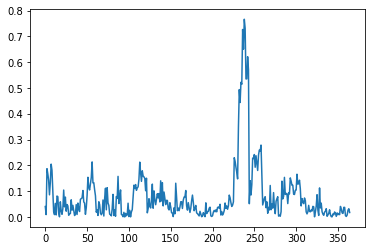

In [18]:
trueprice=trueprice.reshape(365,)
forecase=np.array(forecase)
forecase=forecase.reshape(365,)
error=abs(trueprice-forecase)
error1=error/trueprice
pyplot.plot(error1)
pyplot.show

In [19]:
error2=error*error 
rmse=pow(sum(error2)/365,0.5) 
mae=sum(error)/365
mape=100*sum(error/trueprice)/365
x=np.zeros((365,)) 
y=np.zeros((365,)) 
a=np.zeros((365,)) 
b=np.zeros((365,)) 
c=np.zeros((365,)) 
for i in range(365): 
    if trueprice[i]>=price[i]:
        x[i]=1 
    if forecase[i]>=price[i]: 
        y[i]=1 
for i in range(365): 
    if x[i]==1 and y[i]==1: 
        a[i]=1 
    if x[i]==1 and y[i]==0: 
        b[i]=1 
    if x[i]==0 and y[i]==1: 
        c[i]=1 
precision=sum(a)/(sum(a)+sum(b)) 
recall=sum(a)/(sum(a)+sum(c)) 
f1=2*precision*recall/(precision+recall) 
outcome=np.zeros((371,)) 
for i in range(365): 
    outcome[i]=forecase[i] 
outcome[365]=mae 
outcome[366]=rmse 
outcome[367]=mape
outcome[368]=precision 
outcome[369]=recall 
outcome[370]=f1 
outcome=pd.DataFrame(outcome) 
outcome

,0
0,7337.662109
1,7481.450195
2,8059.949219
3,7894.156250
4,7557.164062
...,...
366,654.516874
367,8.020327
368,0.797872
369,0.541516


In [20]:

outcome.to_csv('data20.csv')

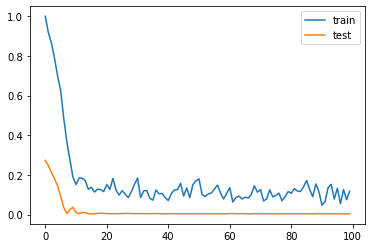

In [21]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [22]:
trueprice.to_csv('trueprice.csv')

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [23]:
trueprice

array([7054.7, 7414.8, 6790.4, 6763.5, 6616.2, 6893.1, 7014.5, 6773.4,
       6830. , 6941. , 7919.9, 7882.5, 8004.9, 8363.3, 8057.1, 7893.1,
       8170. , 8275.7, 8875. , 8944.6, 8811.8, 8954.1, 9661.7, 8855.7,
       9291.4, 8917.8, 9339.2, 9411.2, 9243.2, 9081.3, 9217.1, 9735.9,
       9688.9, 9795. , 9604.9, 9360.6, 9172.7, 9305.4, 9011. , 8407.8,
       8479. , 8698.2, 8660.8, 8462.8, 8344.9, 8064. , 8231.9, 8233.8,
       8518.9, 8390.8, 7989.1, 7500.3, 7572. , 7466. , 7330. , 7325.9,
       7102.6, 7462.6, 7374.9, 7485.6, 7504.2, 7636.1, 7716.8, 7495.5,
       7622. , 7659.8, 7679.4, 7611.9, 7495.1, 6767.9, 6877. , 6547.2,
       6294.2, 6640.7, 6387.6, 6481.4, 6440.8, 6706.6, 6740.2, 6755.4,
       6716.1, 6055.5, 6154.1, 6150.1, 6245.5, 6081.3, 6134.2, 5858.6,
       6196.9, 6387.9, 6345.8, 6617.7, 6495.5, 6584.2, 6526.2, 6595.4,
       6755.1, 6704.7, 6662.5, 6304.6, 6377.9, 6242.5, 6214.9, 6250.4,
       6335.4, 6727. , 7316.9, 7367.4, 7472.3, 7320. , 7396.7, 7401.1,
      

In [24]:
finalprice

,Open,High,Low,Close,Volume (BTC),Volume (Currency),index,biaopu,exchange,gold,nasdaq,niujiaosuo,oil,rate,RSI,mfi,obv,predict
date,,,,,,,,,,,,,,,,,,
2016-10-30,713.949,713.989,688.000,700.917,1750.780129,1.228539e+06,5565,2126.41,6.7858,1273.00,5190.10,10476.62,48.70,0.41,65.293669,61.970862,59041.91285,698.919
2016-10-31,700.079,708.899,685.700,698.919,982.631046,6.878437e+05,4467,2126.15,6.7641,1272.00,5189.14,10481.89,46.86,0.31,60.736373,37.904290,58059.28180,733.744
2016-11-01,698.790,739.488,697.910,733.744,2336.219977,1.702318e+06,4587,2111.72,6.7734,1288.45,5153.58,10414.05,46.67,0.41,86.100549,46.916995,60395.50178,747.070
2016-11-02,733.742,747.070,722.890,747.070,1902.393632,1.390995e+06,6337,2097.94,6.7562,1303.75,5105.57,10334.50,45.34,0.41,89.860276,81.870623,62297.89541,692.179
2016-11-03,747.070,750.500,673.407,692.179,4169.139506,2.969056e+06,6845,2088.66,6.7491,1301.00,5058.41,10307.64,44.66,0.41,33.639305,51.291040,58128.75590,706.036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-27,3919.000,4037.300,3913.000,4025.800,4241.284352,1.693466e+07,8794,2805.37,6.7141,1309.70,7643.38,12591.72,59.41,2.41,76.241999,37.746351,152502.19020,4013.800
2019-03-28,4025.000,4025.000,3994.800,4013.800,2373.315090,9.520079e+06,8908,2815.44,6.7263,1295.15,7669.17,12632.58,59.30,2.41,68.509956,74.500236,150128.87510,4088.900
2019-03-29,4013.300,4100.000,4005.900,4088.900,4465.020015,1.814237e+07,10701,2834.40,6.7335,1295.40,7729.32,12696.88,60.14,2.43,83.868040,100.000000,154593.89510,4090.900
